# Kaggle: Natural Language Processing with Disaster Tweets

[Kaggle competition](https://www.kaggle.com/c/nlp-getting-started)

The goal of this competition is to build a model to identify Twitter posts ("tweets") that are announcing a disaster.  This binary text classification task is important, because it could help state agencies quickly identify and respond to disasters.

The dataset includes 7613 labeled tweets in the training set and 3263 unlabeled tweets in the test set.  Tweets in the dataset appear exactly as on Twitter; they may contain hyperlinks, emojis, hashtags, etc.


In [ ]:
## mount drive if using google colab
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "KAGGLE_USERNAME" # KAGGLE API Credentials redacted
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY" # KAGGLE API Credentials redacted
!kaggle competitions download -c nlp-getting-started
! mkdir input
! unzip /content/nlp-getting-started.zip -d input

In [ ]:
%%capture  
!pip install ktrain
!pip install tensorflow-addons

In [ ]:
import ktrain
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

%matplotlib inline

In [ ]:
#function to plot model training histories
def plot_history(df_history, title):
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    ax[0].plot("epoch", "loss", data = df_history)
    ax[0].plot("epoch", "val_loss", data = df_history)
    fig.axes[0].set_ylabel('loss')
    fig.axes[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot("epoch", "accuracy", data = df_history)
    ax[1].plot("epoch", "val_accuracy", data = df_history)
    fig.axes[1].set_ylabel('accuracy')
    fig.axes[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')

    fig.suptitle(title)
    plt.show()

# create pandas DataFrame from model training history
def df_from_history(history_):
    new_df=pd.DataFrame()
    
    new_df["loss"]=history_.history["loss"]
    new_df["val_loss"]=history_.history["val_loss"]
    new_df["accuracy"]=history_.history["accuracy"]
    new_df["val_accuracy"]=history_.history["val_accuracy"]
    new_df["epoch"] = range(1,new_df.shape[0]+1)

    return new_df

In [ ]:
# Colab paths
train_csv = "/content/input/train.csv"
test_csv = "/content/input/test.csv"
MODEL_DIR = "/content/drive/MyDrive/!Data/kaggle_disaster_tweets/models/"

---
# EDA

In [ ]:
df_test = pd.read_csv(test_csv)
df_train = pd.read_csv(train_csv)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# top-10 training set locations
df_train["location"].value_counts()[:10]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

In [ ]:
# top-10 training set keywords
df_train["keyword"].value_counts()[:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

All training set tweets have text and target values.  Most of the tweets have keywords, and ~2/3 of the tweets have a location.  For now, I will ignore the location data and keywords.  

4 of the top-10 locations represent the United States [USA, New York, United States, Los Angeles CA] but are encoded in different formats.  [India, Mumbai] and [London, UK] demonstrate the same issue.  The location data may be useful, but parsing it would be too time consuming to justify at this point.

The keywords might be worth revisiting, but I will ignore them for now.  The most common keywords are still relatively rare -- present in less than 1% of the tweets -- and many of the top keywords can be used in different contexts. Therefore, there's no reason to suspect that the keywords are too strong of a signal to ignore for now.


Training Dataset: label count
0    4342
1    3271
Name: target, dtype: int64


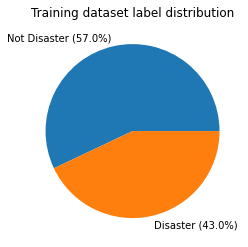

In [ ]:
# Inspect our Training data's label distribution
pie_counts=df_train["target"].value_counts(normalize=True)
print("Training Dataset: label count")
print(df_train["target"].value_counts())
df_train["target"].value_counts().plot(
    kind="pie",
    labels = [f"Not Disaster ({np.round(pie_counts[0]*100)}%)", f"Disaster ({np.round(pie_counts[1]*100)}%)"],
    ylabel="",
    title="Training dataset label distribution"
)
plt.show()

The training set is unbalanced, with a 43-57 split between labels.  This imbalance isn't egregious, so I'll hold off on addressing it for now; however, it might be worth revisiting in the future.


### Wordclouds

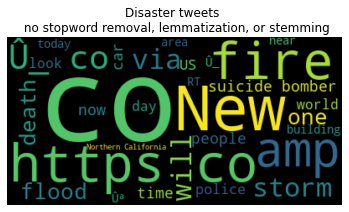

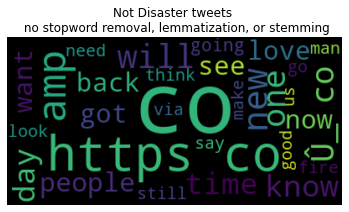

In [ ]:
# Wordclouds of positive and negative labels
pos_train_text = ' '.join(df_train.loc[df_train.target == 1, 'text'])
pos_wordcloud = WordCloud(max_words=30).generate(pos_train_text)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Disaster tweets \n no stopword removal, lemmatization, or stemming")
plt.show()

neg_train_text = ' '.join(df_train.loc[df_train.target == 0, 'text'])
neg_wordcloud = WordCloud(max_words=30).generate(neg_train_text)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Not Disaster tweets \n no stopword removal, lemmatization, or stemming")
plt.show()

These wordclouds show that the most common tokens are generally useless on their own.  Let's see what the wordcloud looks like if we remove stopwords and other meaningless tokens.

In [ ]:
# use the nltk stopword list as a starting point
my_stopwords = set(stopwords.words("english"))

## display most common words -- useful for finding words that should be added to stopword list
# sorted(pos_wordcloud.words_, key=pos_wordcloud.words_.get, reverse=True)[:40]
# sorted(neg_wordcloud.words_, key=neg_wordcloud.words_.get, reverse=True)[:40]

# add these common tokens to the stopword list 
my_stopwords.update(["http co", 'co', 'amp', 'Û_ http', "Û_", 'Ûª', "http", 'https'])



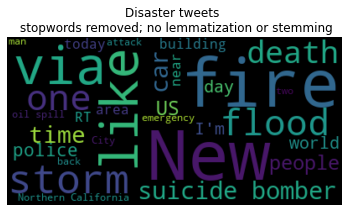

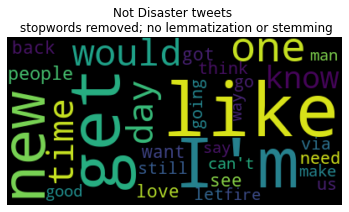

In [ ]:
# Wordclouds of positive and negative labels
pos_train_text = ' '.join(df_train.loc[df_train.target == 1, 'text'])
pos_wordcloud = WordCloud(max_words=30, stopwords=my_stopwords).generate(pos_train_text)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Disaster tweets \n stopwords removed; no lemmatization or stemming")
plt.show()

neg_train_text = ' '.join(df_train.loc[df_train.target == 0, 'text'])
neg_wordcloud = WordCloud(max_words=30, stopwords=my_stopwords).generate(neg_train_text)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Not Disaster tweets \n stopwords removed; no lemmatization or stemming")
plt.show()

These wordclouds look better, but there is still plenty of overlap between common words for both labels.  

This is probably evidence that the presence of specific tokens won't be sufficient for a successful model. We'll need a model that can capture semantic meaning of those words. Fortunately, our RNN and LSTM models should be capable of doing that.

---
# Data preparation / Text preprocessing

In [ ]:
#split df_train into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    df_train["text"].to_numpy(), 
    df_train["target"].to_numpy(),
    train_size = 0.8,
    random_state = 1)

X_test = df_test["text"].to_numpy()

### Text vectorizer layer

Each tweet must be transformed from a string into a matrix representation.  We will accomplish this transformation with a vectorizer layer followed by an embedding layer.

The vectorizer layer splits tweets from a single string into a list of tokens (words).  The tokens will be represented with integers which denote the index of that token.  In our implementation, token indices are determined by counting occurences of each token and sorting them in descending order.  The set of tokens which have a corresponding index representation is known as the "vocabulary".  Tokens which are not represented in the vocabulary are called "out-of-vocabulary" (OOV) tokens and are ignored by the model.  Index 0 and 1 represent masked and OOV tokens respectively.  An example of the vectorizer output can be found below. 

To summarize, the vectorizer layer transforms tweets from a string into a vector of integers which represent tokens.  These vector representations of the tweet are then passed to the embedding layer (discussed below).

In [ ]:
vocab_size = 30000

# Text Vectorizer
vectorizer = layers.TextVectorization(
    max_tokens = vocab_size,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None
)

#include all tokens from test, train, and validation sets because we are using a pre-trained embedding layer
vectorizer.adapt(np.concatenate([X_train, X_test, X_val]))

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# example vectorizer output
print(X_train[0])
vectorizer(X_train[0])

Sioux City Fire Officials Believe Bridge Collapse Lead To Cement Truck Roll Over - Siouxland Matters: Siouxlan... http://t.co/sZTGmbkoHG


<tf.Tensor: shape=(17,), dtype=int64, numpy=
array([11499,   207,    42,   625,   636,   362,   151,  1601,     4,
        8169,   226,  3291,    64, 11497,  4039, 11498, 18128])>

### GloVe embedding  

[Word embedding layers](https://www.tensorflow.org/text/guide/word_embeddings) transform tokens into vectors which (hopefully!) represent the token's meaning.  Tokens with similar meanings should have similar vectors, and tokens with dissimilar meanings should have dissimilar vector representations.

There are many ways to achieve this goal, but I chose to use a [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) embedding (pre-trained on a combined Wikipedia 2014 + GigaWords corpus).  GloVe representations are learned from a matrix of word pair co-occurrences. The Euclidean distance (or cosine similarity) between two word vectors indicates their semantic similarity.  This will hopefully be useful for classifying disaster tweets, since GloVe embeddings should encode the similarity between different types of disasters.  

Using a pre-trained GloVe embedding layer will save time (since I won't need to train my own embedding layer) and help the model recognize disaster-related terms that didn't appear in the training set.  

Another benefit of using a pre-trained embedding layer is that nonsensical tokens such as hyperlinks and emojis are automatically masked.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
# code from https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/pretrained_word_embeddings.ipynb
GLOVE_PATH = "/content/glove.6B.100d.txt"
embedding_dim = 100

embeddings_index = {}
with open(GLOVE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# code from https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/pretrained_word_embeddings.ipynb
num_tokens = len(voc) + 2
hits = 0
misses = 0
misses_dict = {}

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        misses_dict[word] = 0
print("Converted %d words (%d misses)" % (hits, misses))

Converted 14791 words (14574 misses)


Almost half of the tokens in our dataset do not appear in the pre-trained GloVe embedding's index.  This isn't necessarily a cause for concern, nor is it surprising given that we didn't manually remove any nonsensical tokens (hyperlinks, emojis, etc.)

Still, we should take a quick look at the most common OOV tokens and verify that we are satisfied with their omission.

In [ ]:
# look at the top-20 most common words that aren't found in the GloVe embedding matrix
for word in pos_wordcloud.words_.keys():
    if word in misses_dict.keys():
        misses_dict[word] = pos_wordcloud.words_[word]

for word in neg_wordcloud.words_.keys():
    if word in misses_dict.keys():
        misses_dict[word] += neg_wordcloud.word_[word]
        
sorted(misses_dict, key=misses_dict.get, reverse=True)[:20]

['',
 '[UNK]',
 'mh370',
 '\x89Û',
 '\x89ÛÒ',
 '\x89ÛÓ',
 '16yr',
 'prebreak',
 're\x89Û',
 'typhoondevastated',
 'bestnaijamade',
 'nowplaying',
 '11yearold',
 'funtenna',
 'disea',
 'subreddits',
 'reddits',
 'gbbo',
 'don\x89Ûªt',
 'lmao']

These tokens are reasonable to leave out of the model.  Some of the terms ("typhoondevastated", "lmao", "mh370") could be useful, but would require substantial work to integrate into a generalizable model.  

`"Typhoondevastated"` could be split into 2 disaster-related words.  Finding and rectifying this (and similar compound words) would likely improve our model's accuracy. 

`"mh370"` likely refers to the Malaysian Airlines passenger flight which disappeared and probably crashed into the Indian Ocean.  This token might be informative for _this dataset_, but would do little to increase the generalizability of my model. 

Perhaps ironically, I am most concerned about the omission of `"lmao"`.  "Internet-acronyms", memes, and emojis are commonly used to provide context, clarity, and nuance to tweets.  We might successfully incorporate these tokens if we used an embedding that was pre-trained on social media posts from the same time period of our dataset.

In conclusion, some of the omitted tokens are worth revisiting, but we will ignore them for now. 

In [ ]:
# GloVe embedding as a keras layer 
GloVe_embedding = layers.Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

---
# Models

I will compare several RNN variations including: 
* bidirectional RNN
* deep RNN
* LSTM
* bidirectional LSTM

RNN model variants are appropriate for sequential data -- such as natural language data -- and have a proven track record in text classification tasks.  Considering a sentence's tokens _in order_ can pick up on semantic nuance that may be lost if the tokens are considered independently.

### Simple RNN 

In [ ]:
keras.backend.clear_session()

In [ ]:
simple_rnn = keras.models.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.SimpleRNN( units = 64, activation='tanh'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")  
])

In [ ]:
simple_rnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
simple_rnn_history = simple_rnn.fit(
    batch_size=32,
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True,
)

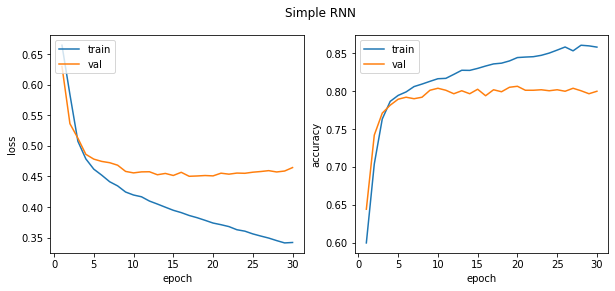

In [ ]:
df_simple_rnn= df_from_history(simple_rnn_history)
plot_history(df_simple_rnn, "Simple RNN")

In [ ]:
# # save model and training history
# df_simple_rnn.to_csv(MODEL_DIR+"df_simple_rnn.csv", index=False)
# simple_rnn.save(MODEL_DIR+"simple_rnn")

### Simple RNN (Dropout)


In [ ]:
keras.backend.clear_session()

In [ ]:
from keras.layers.core.dropout import Dropout
simple_rnn_DO = keras.models.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.Dropout(0.2),
    layers.SimpleRNN( units = 64, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")  
])

simple_rnn_DO.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
simple_rnn_DO_history = simple_rnn_DO.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True
)

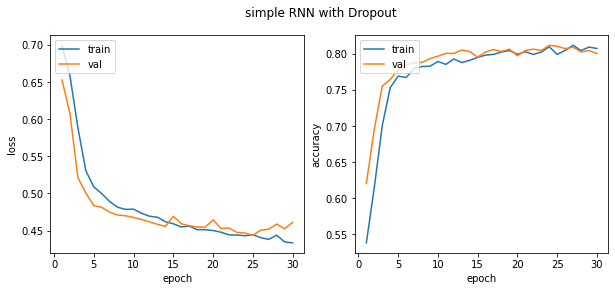

In [ ]:
df_simple_rnn_DO = df_from_history(simple_rnn_DO_history)
plot_history(df_simple_rnn_DO, "simple RNN with Dropout")

In [ ]:
# # save model and training history
# df_simple_rnn_DO.to_csv(MODEL_DIR+"df_simple_rnn_DO.csv", index=False)
# simple_rnn_DO.save(MODEL_DIR+"simple_rnn_DO")

### Bidirectional RNN

In [ ]:
keras.backend.clear_session()

In [ ]:
bi_rnn = keras.models.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.Bidirectional(layers.SimpleRNN(units=64, activation='tanh')),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")  
])

bi_rnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
bi_rnn_history = bi_rnn.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True
)

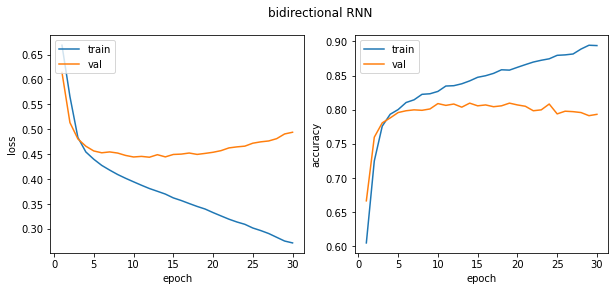

In [ ]:
df_bi_rnn = df_from_history(bi_rnn_history)
plot_history(df_bi_rnn, "bidirectional RNN")

In [ ]:
# # save model and training history
# df_bi_rnn.to_csv(MODEL_DIR+"df_bi_rnn.csv", index=False)
# bi_rnn.save(MODEL_DIR+"bi_rnn")

### Bidirectional RNN (Dropout)

In [ ]:
keras.backend.clear_session()

In [ ]:
bi_rnn_DO = keras.models.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.Dropout(0.2),
    layers.Bidirectional(layers.SimpleRNN(units=64, activation='tanh')),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")  
])

bi_rnn_DO.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
bi_rnn_DO_history = bi_rnn_DO.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True
)

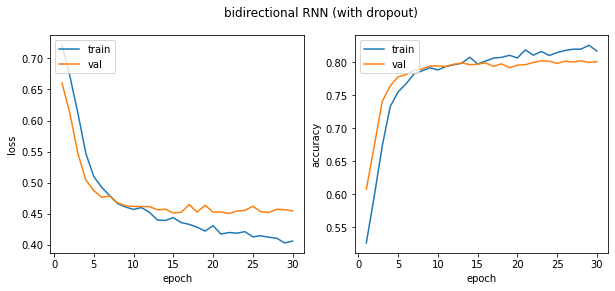

In [ ]:
df_bi_rnn_DO = df_from_history(bi_rnn_DO_history)
plot_history(df_bi_rnn_DO, "bidirectional RNN (with dropout)")

In [ ]:
# # save model and training history
# df_bi_rnn_DO.to_csv(MODEL_DIR+"df_bi_rnn_DO.csv", index=False)
# bi_rnn_DO.save(MODEL_DIR+"bi_rnn_DO")

In [ ]:
keras.backend.clear_session()

In [ ]:
deep_rnn_DO = keras.models.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.Dropout(0.2),
    layers.SimpleRNN(units=64, activation='tanh', return_sequences=True),
    layers.SimpleRNN(units=64, activation='tanh', return_sequences=True),
    layers.SimpleRNN(units=64, activation='tanh', return_sequences=True),
    layers.SimpleRNN(units=64, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")  
])

deep_rnn_DO.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
deep_rnn_DO_history = deep_rnn_DO.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True
)

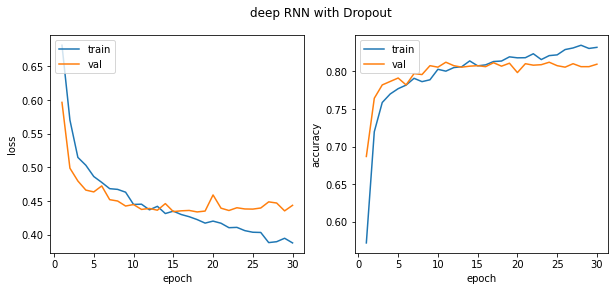

In [ ]:
df_deep_rnn_DO = df_from_history(deep_rnn_DO_history)
plot_history(df_deep_rnn_DO, "deep RNN with Dropout")

In [ ]:
# # save model and training history
# df_deep_rnn_DO.to_csv(MODEL_DIR+"df_deep_rnn_DO.csv", index=False)
# deep_rnn_DO.save(MODEL_DIR+"deep_rnn_DO")

### RNN comparison plot

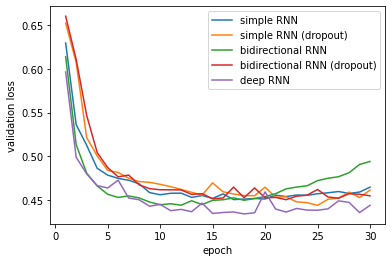

In [ ]:
# plot validation loss of all RNN models
df_simple_rnn = pd.read_csv(MODEL_DIR+"df_simple_rnn.csv")
df_simple_rnn_DO = pd.read_csv(MODEL_DIR+"df_simple_rnn_DO.csv")
df_bi_rnn = pd.read_csv(MODEL_DIR+"df_bi_rnn.csv")
df_bi_rnn_DO = pd.read_csv(MODEL_DIR+"df_bi_rnn_DO.csv")
df_deep_rnn_DO = pd.read_csv(MODEL_DIR+"df_deep_rnn_DO.csv")

plt.plot("epoch", "val_loss", data = df_simple_rnn, label="simple RNN")
plt.plot("epoch", "val_loss", data = df_simple_rnn_DO, label="simple RNN (dropout)")
plt.plot("epoch", "val_loss", data = df_bi_rnn, label="bidirectional RNN")
plt.plot("epoch", "val_loss", data = df_bi_rnn_DO, label="bidirectional RNN (dropout)")
plt.plot("epoch", "val_loss", data = df_deep_rnn_DO, label="deep RNN")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.show()

Of the models we have seen so far, the deep RNN has the lowest validation loss.  The difference between models is incremental, so there is little reason to continue tweaking these RNN models.  Instead, let's move on to LSTM model variants.

### Simple LSTM

In [ ]:
lstm = keras.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.LSTM(64, activation="tanh"),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
lstm_history = lstm.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True
)

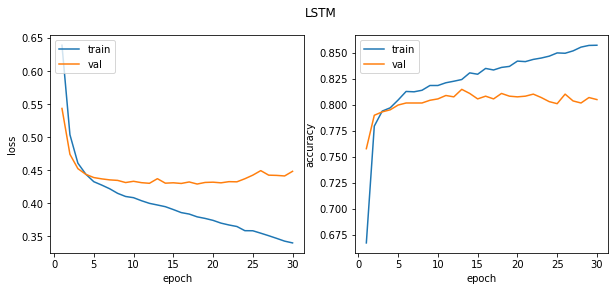

In [ ]:
df_lstm = df_from_history(lstm_history)
plot_history(df_lstm, "LSTM")

In [ ]:
# # save model and training history
# df_lstm.to_csv(MODEL_DIR+"df_lstm.csv", index=False)
# lstm.save(MODEL_DIR+"lstm")

### Bidirectional LSTM

In [ ]:
keras.backend.clear_session()

In [ ]:
bi_lstm = keras.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.Bidirectional(layers.LSTM(64, activation="tanh")),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

bi_lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
bi_lstm_history = bi_lstm.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True
)

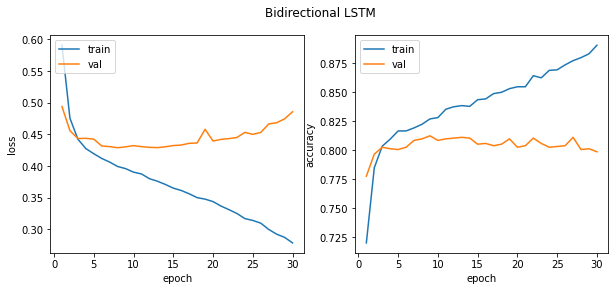

In [ ]:
df_bi_lstm = df_from_history(bi_lstm_history)
plot_history(df_bi_lstm, "Bidirectional LSTM")

In [ ]:
# # save model and training history
# df_bi_lstm.to_csv(MODEL_DIR+"df_bi_lstm.csv", index=False)
# bi_lstm.save(MODEL_DIR+"bi_lstm")

### Bidirectional LSTM (dropout)

In [ ]:
bi_lstm_DO = keras.Sequential([
    vectorizer,
    GloVe_embedding,
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64, activation="tanh", recurrent_dropout=0.2)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

bi_lstm_DO.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])

In [ ]:
bi_lstm_DO_history = bi_lstm_DO.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True
)

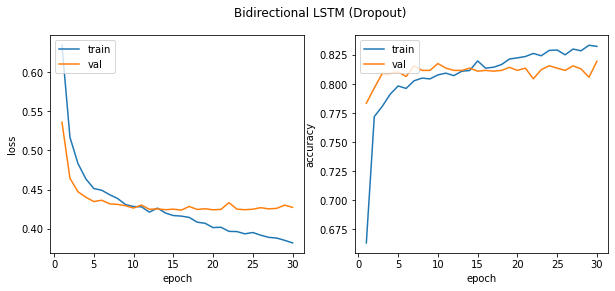

In [ ]:
df_bi_lstm_DO = df_from_history(bi_lstm_DO_history)
plot_history(df_bi_lstm_DO, "Bidirectional LSTM (Dropout)")

In [ ]:
# # save model and training history
# df_bi_lstm_DO.to_csv(MODEL_DIR+"df_bi_lstm_DO.csv", index=False)
# bi_lstm_DO.save(MODEL_DIR+"bi_lstm_DO")

There doesn't appear to be much difference between the LSTM variations, although they seem better than the RNN models

---
# Results / Model Comparison

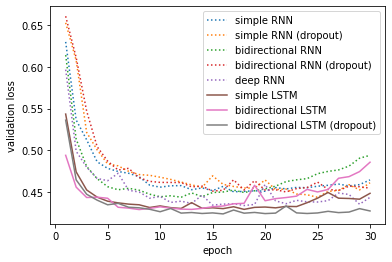

In [ ]:
# plot validation loss of all RNN and LSTM models
df_lstm = pd.read_csv(MODEL_DIR+"df_lstm.csv")
df_bi_lstm = pd.read_csv(MODEL_DIR+"df_bi_lstm.csv")
df_bi_lstm_DO = pd.read_csv(MODEL_DIR+"df_bi_lstm_DO.csv")


plt.plot("epoch", "val_loss", data = df_simple_rnn, label="simple RNN", linestyle="dotted")
plt.plot("epoch", "val_loss", data = df_simple_rnn_DO, label="simple RNN (dropout)", linestyle="dotted")
plt.plot("epoch", "val_loss", data = df_bi_rnn, label="bidirectional RNN", linestyle="dotted")
plt.plot("epoch", "val_loss", data = df_bi_rnn_DO, label="bidirectional RNN (dropout)", linestyle="dotted")
plt.plot("epoch", "val_loss", data = df_deep_rnn_DO, label="deep RNN", linestyle="dotted")


plt.plot("epoch", "val_loss", data = df_lstm, label="simple LSTM")
plt.plot("epoch", "val_loss", data = df_bi_lstm, label="bidirectional LSTM")
plt.plot("epoch", "val_loss", data = df_bi_lstm_DO, label="bidirectional LSTM (dropout)")

plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.show()

| model_name | cell layers (units) | FC layers (units) | dropout? | best val_loss | best val_acc |
|---         | ---   | ---       | ---      | ---           | ---    |
| simple_rnn | RNN (64) | 1 (64) | no | 0.4502 | 0.8063  |
| simple_rnn_DO | RNN (64) | 1 (64) | yes | 0.4436 | 0.8116  |
| bi_rnn | bidirectional RNN (2x64)  |  1 (64)  |  no | 0.4437 | 0.8096 |
| bi_rnn_DO | bidirectional RNN (2x64) |  1 (64) | yes | 0.4500 | 0.8024 |
| deep_rnn_DO | 4x RNN (64) | 1 (64) | yes | 0.4337 | 0.8122 |
|     |    |    |     |    |     | 
| lstm | LSTM (64) | 1 (64) | no | 0.4291 | 0.8148 |
| bi_lstm | bidirectional LSTM (2x64) | 1 (64) | no  |  0.4289   | 0.8122 |
| bi_lstm_DO | bidirectional LSTM (2x64) | 1 (64) | yes  | **0.4237** | **0.8194** | 
  



All LSTM models outperformed all RNN models, but the difference between top performing models is marginal.

---
# Model tuning

So far, we have put little thought into the learning rate.  Learning rate is an important hyperparameter that can have a major impact on the quality of a trained model.  It is worth spending a little time to ensure that we are using an appropriate learning rate for our best performing model.

I will use [ktrain](https://github.com/amaiya/ktrain) to find an ideal learning rate and implement a [cyclical learning rate](https://arxiv.org/pdf/1506.01186.pdf).

In [ ]:
lstm_learner = ktrain.get_learner(
    model=bi_lstm_DO,
    train_data=(X_train, y_train),
    val_data=(X_val, y_val)
)

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
191/191 [==============================] - 43s 202ms/step - loss: 0.6890 - accuracy: 0.5407
Epoch 2/1024
191/191 [==============================] - 39s 203ms/step - loss: 0.6866 - accuracy: 0.5430
Epoch 3/1024
191/191 [==============================] - 40s 207ms/step - loss: 0.6755 - accuracy: 0.5860
Epoch 4/1024
191/191 [==============================] - 39s 203ms/step - loss: 0.6238 - accuracy: 0.6749
Epoch 5/1024
191/191 [==============================] - 38s 201ms/step - loss: 0.4909 - accuracy: 0.7755
Epoch 6/1024
191/191 [==============================] - 38s 201ms/step - loss: 0.4768 - accuracy: 0.7796
Epoch 7/1024
191/191 [==============================] - 38s 201ms/step - loss: 0.4938 - accuracy: 0.7777
Epoch 8/1024
191/191 [==============================] - 39s 202ms/step - loss: 1.6751 - accuracy: 0.5985
Epoch 9/1024
191/191 [==============================] - 16s 81ms/step - loss:

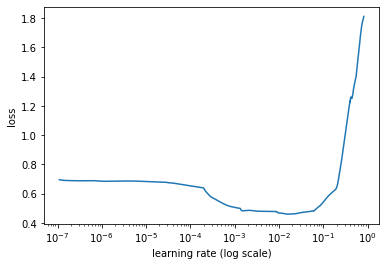

In [ ]:
lstm_learner.reset_weights() 
lstm_learner.lr_find(restore_weights_only=True, show_plot=True)

In [ ]:
lstm_learner_history = lstm_learner.autofit(
    lr=1e-3,
    early_stopping=10,
    reduce_on_plateau=3)

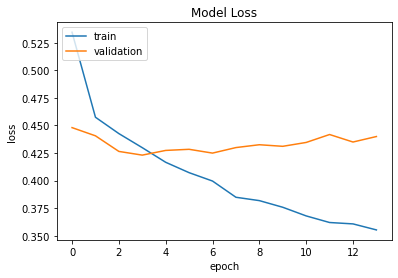

In [ ]:
lstm_learner.plot("loss")

Optimizing the learning rate did not improve the final quality of our model; however, we reached the minimum validation loss many epochs earlier than before.

---
# Comparison to out-of-the-box transformer model (DistilBERT)




So far, all RNN and LSTM models have had fairly similar (and disappointing) performance.  This gives me reason to suspect that the issue lies with my text cleaning/preprocessing rather than model architecture.

To test this suspicion, I'll use an "out-of-the-box" pre-trained transformer model (DistilBERT).  Pre-trained transformer models are the current state-of-the-art for NLP tasks, so it is likely to outperform my RNN models.  Transformer embeddings are distinct from GloVe, so the only similarities in the DistilBERT pipeline and my RNN pipelines will be the raw text data.

If DistilBERT's performance is underwhelming, it will strongly indicate that the raw tweets are insufficient. Such a result would call for further cleaning and parsing of the data.

In [ ]:
keras.backend.clear_session()

In [ ]:
t = ktrain.text.Transformer(
    model_name='distilbert-base-uncased', 
    maxlen=256, 
    class_names=["negative", "positive"])

train_data = t.preprocess_train(X_train, y=y_train)
val_data = t.preprocess_test(X_val, y=y_val)
model = t.get_classifier()
bert_learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=16)

In [ ]:
bert_learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
380/380 [==============================] - 114s 268ms/step - loss: 0.6771 - accuracy: 0.5375
Epoch 2/1024
380/380 [==============================] - 103s 271ms/step - loss: 0.4428 - accuracy: 0.8067
Epoch 3/1024
380/380 [==============================] - 103s 271ms/step - loss: 0.6501 - accuracy: 0.6016
Epoch 4/1024
380/380 [==============================] - 104s 273ms/step - loss: 0.8290 - accuracy: 0.5591
Epoch 5/1024
380/380 [==============================] - 55s 144ms/step - loss: 11665.0293 - accuracy: 0.5231


done.
Visually inspect loss plot and select learning rate associated with falling loss


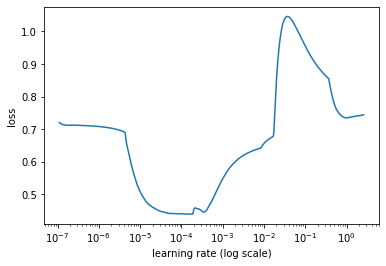

In [ ]:
bert_learner.lr_find(show_plot=True)

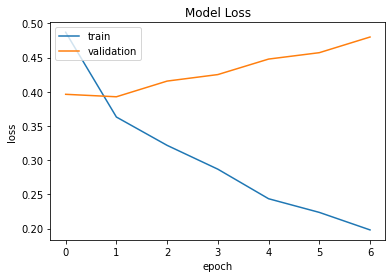

In [ ]:
bert_history = bert_learner.autofit(lr=1e-5)
bert_learner.plot("loss")

DistilBERT evaluation metrics:

val_loss: 0.3927

val_acc:  0.8313

---
# Conclusion

LSTM models outperformed RNN models, although the difference was slight.  None of these models were able to exceed a validation accuracy of 0.82.  The difference in performance between LSTM variants was small enough that it may be due to random chance.

Learning rate tuning improved model training time, but did not make the model more accurate.

The DistilBERT model outperformed all RNN and LSTM models by a convincing margin, but the validation accuracy was still disappointing (0.8313).  This result indicates that all models are likely to struggle with the raw dataset.  **Better performance will surely require additional cleaning/processing of the texts.**

---

# Next Steps / Future Improvements
Cleaning and augmenting the data is the obvious next step.  This may include:
* identifying and correcting misspelled and "fused" words (like "typhoondevastation").
* incorporate emojis in the word embedding
* trying a GloVe embedding pre-trained on a Twitter corpus
* augmenting the data by incorporating text data from linked webpages 



---
# Reference list:
* Cyclical learning rates
    * https://arxiv.org/pdf/1506.01186.pdf
* GloVe
    * https://nlp.stanford.edu/projects/glove/
    * https://nlp.stanford.edu/pubs/glove.pdf
* Word Embeddings
    * https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
## predict on test set
# test_data = t.preprocess_test(X_test)
# test_predictions = bert_learner.predict(test_data)
# test_predictions=np.argmax(test_predictions, axis=1)

## save predictions as submission.csv
# df_submission=pd.read_csv("/content/input/sample_submission.csv")
# df_submission["target"] = test_predictions
# df_submission.to_csv("submission.csv", index=False)